<a href="https://colab.research.google.com/github/Nikitaion/TensorFlowLearning/blob/main/07_food_vision_milestone_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07. Milestone Project 1: 🍔👁 Food Vision Big™


We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

This time **we've got the goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

> 🔑 **Note:** **Top-1 accuracy** means "accuracy for the top softmax activation value output by the model" (because softmax ouputs a value for every class, but top-1 means only the highest one is evaluated). **Top-5 accuracy** means "accuracy for the top 5 softmax activation values output by the model", in other words, did the true label appear in the top 5 activation values? Top-5 accuracy scores are usually noticeably higher than top-1.

|  | 🍔👁 Food Vision Big™ | 🍔👁 Food Vision mini |
|-----|-----|-----|
| Dataset source | TensorFlow Datasets | Preprocessed download from Kaggle | 
| Train data | 75,750 images | 7,575 images | 
| Test data | 25,250 images | 25,250 images | 
| Mixed precision | Yes | No |
| Data loading | Performanant tf.data API | TensorFlow pre-built function |  
| Target results | 77.4% top-1 accuracy (beat [DeepFood paper](https://arxiv.org/abs/1606.05675)) | 50.76% top-1 accuracy (beat [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)) | 

*Table comparing difference between Food Vision Big (this notebook) versus Food Vision mini (previous notebook).*

Alongside attempting to beat the DeepFood paper, we're going to learn about two methods to significantly improve the speed of our model training:
1. Prefetching
2. Mixed precision training

But more on these later.

## What we're going to cover

* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (**making our datasets run fast**)
* Creating modelling callbacks
* Setting up **mixed precision training**
* Building a feature extraction model (see [transfer learning part 1: feature extraction](https://github.com/Nikitaion/TensorFlowLearning/blob/main/01_neural_network_regression_with_tensorflow.ipynb))
* Fine-tuning the feature extraction model (see [transfer learning part 2: fine-tuning](https://github.com/Nikitaion/TensorFlowLearning/blob/main/02_neural_network_classification_with_tensorflow.ipynb))
* Viewing training results on TensorBoard

## Check GPU

For this notebook, we're going to be doing something different.

We're going to be using mixed precision training.

Mixed precision training was introduced in [TensorFlow 2.4.0](https://blog.tensorflow.org/2020/12/whats-new-in-tensorflow-24.html) (a very new feature at the time of writing).

What does **mixed precision training** do?

Mixed precision training uses a combination of single precision (float32) and half-preicison (float16) data types to speed up model training (up 3x on modern GPUs).

We'll talk about this more later on but in the meantime you can read the [TensorFlow documentation on mixed precision](https://www.tensorflow.org/guide/mixed_precision) for more details.

For now, before we can move forward if we want to use mixed precision training, we need to make sure the GPU powering our Google Colab instance (if you're using Google Colab) is compataible. 

For mixed precision training to work, you need access to a GPU with a compute compability score of 7.0+. 

Google Colab offers P100, K80 and T4 GPUs, however, **the P100 and K80 aren't compatible with mixed precision training**.

Therefore before we proceed we need to make sure we have **access to a Tesla T4 GPU in our Google Colab instance**.

If you're not using Google Colab, you can find a list of various [Nvidia GPU compute capabilities on Nvidia's developer website](https://developer.nvidia.com/cuda-gpus#compute).

> 🔑 **Note:** If you run the cell below and see a P100 or K80, try going to to Runtime -> Factory Reset Runtime (note: this will remove any saved variables and data from your Colab instance) and then retry to get a T4.
>
> **You can still run the code *without* a GPU capable of mixed precision** (it'll just be a little slower). 

In [1]:
# If using Google Colab, this should output "Tesla T4" otherwise, 
# you won't be able to use mixed precision training
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-61dd13fa-a29a-4d68-4af2-35213eebb1b4)


In [2]:
# Hide warning logs (see: https://stackoverflow.com/a/38645250/7900723)
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(tf.__version__)

2.7.0


In [3]:
# Get helper functions file
if not os.path.exists("helper_functions.py"):
    print("Downloading helper functions...")
    !wget https://raw.githubusercontent.com/Nikitaion/TensorFlowLearning/main/extras/helper_functions.py
else:
    print("Helper functions file already exists, skipping download...")

--2022-01-18 07:00:56--  https://raw.githubusercontent.com/Nikitaion/TensorFlowLearning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-18 07:00:56 (108 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

In previous notebooks, we've downloaded our food images (from the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101/home)) from Google Storage.

And this is a typical workflow you'd use if you're working on your own datasets.

However, there's another way to get datasets ready to use with TensorFlow.

For many of the most popular datasets in the machine learning world (often referred to and used as benchmarks), you can access them through [TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview).

What is **TensorFlow Datasets**?

A place for prepared and ready-to-use machine learning datasets.

Why use TensorFlow Datasets?

* Load data already in Tensors
* Practice on well established datasets
* Experiment with differet data loading techniques (like we're going to use in this notebook)
* Experiment with new TensorFlow features quickly (such as mixed precision training)

Why *not* use TensorFlow Datasets?

* The datasets are static (they don't change, like your real-world datasets would)
* Might not be suited for your particular problem (but great for experimenting)

To begin using TensorFlow Datasets we can import it under the alias `tfds`.


In [5]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

To find all of the available datasets in TensorFlow Datasets, you can use the `list_builders()` method.

After doing so, we can check to see if the one we're after (`"food101"`) is present.

In [6]:
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?

True


Beautiful! It looks like the dataset we're after is available (note there are plenty more available but we're on Food101).

To get access to the Food101 dataset from the TFDS, we can use the [`tfds.load()`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method.

In particular, we'll have to pass it a few parameters to let it know what we're after:
* `name` (str) : the target dataset (e.g. `"food101"`)
* `split` (list, optional) : what splits of the dataset we're after (e.g. `["train", "validation"]`)
  * the `split` parameter is quite tricky. See [the documentation for more](https://github.com/tensorflow/datasets/blob/master/docs/splits.md).
* `shuffle_files` (bool) : whether or not to shuffle the files on download, defaults to `False` 
* `as_supervised` (bool) : `True` to download data samples in tuple format (`(data, label)`) or `False` for dictionary format 
* `with_info` (bool) : `True` to download dataset metadata (labels, number of samples, etc)

> 🔑 **Note:** Calling the `tfds.load()` method will start to download a target dataset to disk if the `download=True` parameter is set (default). This dataset could be 100GB+, so make sure you have space.

In [16]:
# Load in the data 
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

In [8]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    version=2.0.0,
    description='This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.',
    homepage='https://www.vision.ee.ethz.ch/datasets_extra/food-101/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    total_num_examples=101000,
    splits={
        'train': 75750,
        'validation': 25250,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{bossard14,
      title = {Food-101 -- Mining Discriminative Components with Random Forests},
      

After a few minutes of downloading, we've now got access to entire Food101 dataset (in tensor format) ready for modelling.

Now let's get a little information from our dataset, starting with the class names.

Getting class names from a TensorFlow Datasets dataset requires downloading the "`dataset_info`" variable (by using the `as_supervised=True` parameter in the `tfds.load()` method, **note:** this will only work for supervised datasets in TFDS).

We can access the class names of a particular dataset using the `dataset_info.features` attribute and accessing `names` attribute of the the `"label"` key.

In [9]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [10]:
# Get the class names
class_names = ds_info.features["label"].names   # .names will give us class names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Exploring the Food101 data from TensorFlow Datasets

Let's find out a few details about our dataset:
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

To do, let's take one sample off the training data (using the [`.take()` method](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take)) and explore it. 

In [17]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

Because we used the `as_supervised=True` parameter in our `tfds.load()` method above, data samples come in the tuple format structure `(data, label)` or in our case `(image_tensor, label)`.

In [18]:
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [36]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Targer class from Food101 (tensor form): {label}
  Class name (as String): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Targer class from Food101 (tensor form): 75
  Class name (as String): pho
  


Because we set the `shuffle_files=True` parameter in our `tfds.load()` method above, running the cell above a few times will give a different result each time.

Checking these you might notice some of the images have different shapes, for example `(512, 342, 3)` and `(512, 512, 3)` (height, width, color_channels).

Let's see what one of the image tensors from TFDS's Food101 dataset looks like.

In [38]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 95,  95,  25],
        [ 87,  87,  17],
        [ 96,  93,  26],
        ...,
        [178, 189, 191],
        [180, 191, 193],
        [178, 189, 191]],

       [[ 92,  92,  22],
        [ 86,  86,  16],
        [ 91,  88,  21],
        ...,
        [183, 194, 196],
        [184, 195, 197],
        [180, 191, 193]],

       [[ 97,  94,  25],
        [ 92,  89,  20],
        [ 89,  86,  19],
        ...,
        [187, 198, 200],
        [185, 199, 200],
        [181, 195, 196]],

       ...,

       [[205, 196, 155],
        [205, 196, 155],
        [203, 194, 155],
        ...,
        [216, 228, 226],
        [214, 226, 224],
        [207, 219, 217]],

       [[209, 197, 155],
        [210, 198, 156],
        [207, 198, 159],
        ...,
        [216, 228, 226],
        [212, 224, 222],
        [212, 224, 222]],

       [[202, 191, 146],
        [207, 195, 153],
        [207, 198, 157],
        ...,
        [217, 229, 22

In [21]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Alright looks like our image tensors have values of between 0 & 255 (standard red, green, blue colour values) and the values are of data type `unit8`.

We might have to preprocess these before passing them to a neural network. But we'll handle this later.

In the meantime, let's see if we can plot an image sample.

### Plot an image from TensorFlow Datasets

Let's plot one of the image samples using [`matplotlib.pyplot.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) and set the title to target class name.

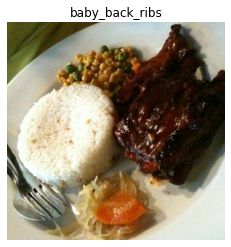

In [23]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

In [26]:
label.numpy()

1

## Create preprocessing functions for our data

In previous notebooks, when our images were in folder format we used the method [`tf.keras.preprocessing.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) to load them in.

Doing this meant our data was loaded into a format ready to be used with our models.

However, since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model. 

More specifically, our data is currently:

* In `uint8` data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`)
* Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize)
* Converts an input image tensor's current datatype to `tf.float32` using [`tf.cast()`](https://www.tensorflow.org/api_docs/python/tf/cast)

> 🔑 **Note:** Pretrained EfficientNetBX models in [`tf.keras.applications.efficientnet`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet) (what we're going to be using) have rescaling built-in. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1). This could be incorporated inside your "`preprocess_img()`" function (like the one below) or within your model as a [`tf.keras.layers.experimental.preprocessing.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [27]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  return tf.cast(image, tf.float32), label # convert image to float32 type and return (float32_image, label) tuple

Our `preprocess_img()` function above takes image and label as input (even though it does nothing to the label) because our dataset is currently in the tuple structure `(image, label)`.

Let's try our function out on a target image.

In [42]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0] # preprocess_img returns (float32_image, label) so we only take the 0 element (image)
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 95  95  25]
  [ 87  87  17]
  [ 96  93  26]
  ...
  [178 189 191]
  [180 191 193]
  [178 189 191]]

 [[ 92  92  22]
  [ 86  86  16]
  [ 91  88  21]
  ...
  [183 194 196]
  [184 195 197]
  [180 191 193]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 88.755104  88.755104  18.755102]
  [ 88.341835  85.341835  18.341835]
  [ 86.377556  81.16327   17.591837]
  ...
  [182.5153   193.5153   195.5153  ]
  [181.47958  192.47958  194.47958 ]
  [181.39784  192.39784  194.39784 ]]

 [[ 96.57143   93.57143   24.571428]
  [ 92.38265   89.38265   22.382656]
  [ 93.72959   88.515305  24.94388 ]
  ...
  [189.42863  200.42863  202.42863 ]
  [189.78568  200.78568  202.78568 ]
  [183.90295  197.90295  198.90295 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


Looks like our `preprocess_img()` function is working as expected.

The input image gets converted from `uint8` to `float32` and gets reshaped from its current shape to `(224, 224, 3)`.

How does it look?

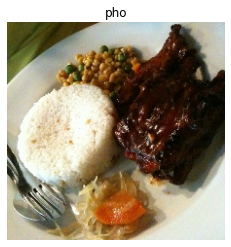

In [45]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

## Batch & prepare datasets

Before we can model our data, we have to turn it into batches.

Why?

Because computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the [`tf.data` API](https://www.tensorflow.org/api_docs/python/tf/data).

> 📖 **Resource:** For loading data in the most performant way possible, see the TensorFlow docuemntation on [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance).

Specifically, we're going to be using:

* [`map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) - maps a predefined function to a target dataset (e.g. `preprocess_img()` to our image tensors)
* [`shuffle()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) - randomly shuffles the elements of a target dataset up `buffer_size` (ideally, the `buffer_size` is equal to the size of the dataset, however, this may have implications on memory)
* [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) - turns elements of a target dataset into batches (size defined by parameter `batch_size`)
* [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* Extra: [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory) 

Things to note:
- Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our `preprocess_img()` function)
- `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
- For methods with the `num_parallel_calls` parameter available (such as `map()`), setting it to`num_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
- Can't use `cache()` unless your dataset can fit in memory

Woah, the above is alot. But once we've coded below, it'll start to make sense.

We're going to through things in the following order:

```
Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset
```

This is like saying, 

> "Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batch".

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-prefetching-from-hands-on-ml.png)

*What happens when you use prefetching (faster) versus what happens when you don't use prefetching (slower). **Source:** Page 422 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).*


In [48]:
train_data

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [49]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE) # num_parallel_calls=tf.data.AUTOTUNE for utilize all cpu
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # buffer_size - how many will shuffle at the same time

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [55]:
# And now let's check out what our prepared datasets look like.
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

 Looks like our data is now in tutples of `(image, label)` with datatypes of `(tf.float32, tf.int64)`, just what our model is after.

> 🔑 **Note:** You can get away without calling the `prefetch()` method on the end of your datasets, however, you'd probably see significantly slower data loading speeds when building a model. So most of your dataset input pipelines should end with a call to [`prefecth()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch).

Onward.

## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:
* [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - allows us to keep track of our model's training history so we can inspect it later (**note:** we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* [`tf.keras.callbacks.ModelCheckpoint()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
  * Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [56]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=1) # don't print out whether or not model is being saved 

## Setup mixed precision training

We touched on mixed precision training above.

However, we didn't quite explain it.

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

In computer science, float32 is also known as [single-precision floating-point format](https://en.wikipedia.org/wiki/Single-precision_floating-point_format). The 32 means it usually occupies 32 bits in computer memory.

Your GPU has a limited memory, therefore it can only handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.

Mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.

Can you guess what float16 means?

Well, if you thought since float32 meant single-precision floating-point, you might've guessed float16 means [half-precision floating-point format](https://en.wikipedia.org/wiki/Half-precision_floating-point_format). And if you did, you're right! And if not, no trouble, now you know.

For tensors in float16 format, each element occupies 16 bits in computer memory.

So, where does this leave us?

As mentioned before, when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.

For a more detailed explanation, I encourage you to read through the [TensorFlow mixed precision guide](https://www.tensorflow.org/guide/mixed_precision) (I'd highly recommend at least checking out the summary).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-speedup-equals-3x-gpu.png)
*Because mixed precision training uses a combination of float32 and float16 data types, you may see up to a 3x speedup on modern GPUs.*

> 🔑 **Note:** If your GPU doesn't have a score of over 7.0+ (e.g. P100 in Colab), mixed precision won't work (see: ["Supported Hardware"](https://www.tensorflow.org/guide/mixed_precision#supported_hardware) in the mixed precision guide for more).

> 📖 **Resource:** If you'd like to learn more about precision in computer science (the detail to which a numerical quantity is expressed by a computer), see the [Wikipedia page](https://en.wikipedia.org/wiki/Precision_(computer_science)) (and accompanying resources). 

Okay, enough talk, let's see how we can turn on mixed precision training in TensorFlow.

The beautiful thing is, the [`tensorflow.keras.mixed_precision`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/) API has made it very easy for us to get started.

First, we'll import the API and then use the [`set_global_policy()`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/set_global_policy) method to set the *dtype policy* to `"mixed_float16"`.


In [57]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [63]:
mixed_precision.global_policy() # slould output "mixed_float16"

<Policy "mixed_float16">

## Build feature extraction model

Callbacks: ready to roll.

Mixed precision: turned on.

Let's build a model.

Because our dataset is quite large, we're going to move towards fine-tuning an existing pretrained model (EfficienetNetB0).

But before we get into fine-tuning, let's set up a feature-extraction model.

Recall, the typical order for using transfer learning is:

1. Build a feature extraction model (replace the top few layers of a pretrained model) 
2. Train for a few epochs with lower layers frozen
3. Fine-tune if necessary with multiple layers unfrozen

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-feature-extraction-then-fine-tune.png)
*Before fine-tuning, it's best practice to train a feature extraction model with custom top layers.*

To build the feature extraction model (covered in [Transfer Learning in TensorFlow Part 1: Feature extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb)), we'll:
* Use `EfficientNetB0` from [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) pre-trained on ImageNet as our base model
  * We'll download this without the top layers using `include_top=False` parameter so we can create our own output layers
* Freeze the base model layers so we can use the pre-learned patterns the base model has found on ImageNet
* Put together the input, base model, pooling and output layers in a [Functional model](https://keras.io/guides/functional_api/)
* Compile the Functional model using the Adam optimizer and [sparse categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) as the loss function (since our labels **aren't** one-hot encoded)
* Fit the model for 3 epochs using the TensorBoard and ModelCheckpoint callbacks

> 🔑 **Note:** Since we're using mixed precision training, our model needs a separate output layer with a hard-coded `dtype=float32`, for example, `layers.Activation("softmax", dtype=tf.float32)`. This ensures the outputs of our model are returned back to the float32 data type which is more numerically stable than the float16 datatype (important for loss calculations). See the ["Building the model"](https://www.tensorflow.org/guide/mixed_precision#building_the_model) section in the TensorFlow mixed precision guide for more.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-code-before-and-after.png)
*Turning mixed precision on in TensorFlow with 3 lines of code.*

In [69]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer", dtype=tf.float16)

# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only (makes sure layers which should be in inference mode only stay like that)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 

# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot"
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [70]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policies (are we using mixed precision?)

Model ready to go!

Before we said the mixed precision API will automatically change our layers' dtype policy's to whatever the global dtype policy is (in our case it's `"mixed_float16"`).

We can check this by iterating through our model's layers and printing layer attributes such as `dtype` and `dtype_policy`.

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

Going through the above we see:
* `layer.name` (str) : a layer's human-readable name, can be defined by the `name` parameter on construction
* `layer.trainable` (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's `trainable` attribute to `False`
* `layer.dtype` : the data type a layer stores its variables in
* `layer.dtype_policy` : the data type a layer computes in

> 🔑 **Note:** A layer can have a dtype of `float32` and a dtype policy of `"mixed_float16"` because it stores its variables (weights & biases) in `float32` (more numerically stable), however it computes in `float16` (faster).

We can also check the same details for our model's base model.


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

> 🔑 **Note:** The mixed precision API automatically causes layers which can benefit from using the `"mixed_float16"` dtype policy to use it. It also prevents layers which shouldn't use it from using it (e.g. the normalization layer at the start of the base model).

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

In [ ]:
# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3.
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data, # train data shuffled, test data not shuffled
                                                     validtion_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

And since we used the `ModelCheckpoint` callback, we've got a saved version of our model in the `model_checkpoints` directory.

Let's load it in and make sure it performs just as well.

## Load and evaluate checkpoint weights

We can load in and evaluate our model's checkpoints by:

1. Cloning our model using [`tf.keras.models.clone_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model) to make a copy of our feature extraction model with reset weights.
2. Calling the `load_weights()` method on our cloned model passing it the path to where our checkpointed weights are stored.
3. Calling `evaluate()` on the cloned model with loaded weights.

A reminder, checkpoints are helpful for when you perform an experiment such as fine-tuning your model. In the case you fine-tune your feature extraction model and find it doesn't offer any improvements, you can always revert back to the checkpointed version of your model.

In [ ]:
# Clone the model we created (this resets all weights)
cloned_model = = tf.keras.models.clone_model(model)
cloned_model.summary()

In [ ]:
!ls model_checkpoints/

In [ ]:
# Where are our checkpoints stored?
checkpoint_path